# Exploratory Data Analysis (of Everything)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats 
import size.viz
import size.analytical
import seaborn as sns
carbons = ['acetate', 'sorbitol', 'glycerol', 'glucose', 'glucoseCAA', 'RDM', 'ezMOPS', 'LB']
cmap = sns.color_palette("ch:start=.2,rot=-.3", n_colors=len(carbons) + 2).as_hex()
carb_colors = {c:k for c, k in zip(carbons, cmap[2:])}
cor, pal = size.viz.matplotlib_style()

In [2]:
# Load the various datasets 
sizes = pd.read_csv('../../data/summaries/summarized_size_measurements.csv')
sizes.dropna(inplace=True)
sizes = sizes[sizes['temperature_C']==37]
wt_sizes = sizes[(sizes['strain']=='wildtype') & (sizes['inducer_conc']==0)]
growth_rates = pd.read_csv('../../data/summaries/summarized_growth_measurements.csv')
growth_rates_agg = growth_rates.groupby(['strain', 'carbon_source']
                          )['growth_rate_hr'].agg(('mean', 'sem')).reset_index()

cell_counts = pd.read_csv('../../data/summaries/flow_cytometry_counts.csv')
cell_counts_agg = cell_counts.groupby(['strain', 'carbon_source', 'overexpression', 
                                       'inducer', 'inducer_conc', 'date']
                                       )['cells_per_biomass'].agg(
                                        ('mean')).reset_index()
cell_counts_errs = cell_counts_agg.groupby(['strain', 'carbon_source']
                       )['cells_per_biomass'].agg(('mean', 'sem')).reset_index()
protein = pd.read_csv('../../data/summaries/summarized_protein_measurements.csv')
protein_agg = protein.groupby(['strain', 'carbon_source', 'overexpression', 
                               'inducer', 'inducer_conc_ng_ml']
                     )['prot_ug_per_biomass'].agg(('mean', 'sem')).reset_index()

## Exploring Replicate Variability

In [3]:
sizes.carbon_source.unique()

array(['glucoseCAA', 'glucose', 'glycerol', 'LB', 'acetate', 'sorbitol',
       'ezMOPS', 'RDM'], dtype=object)

## Exploring Growth Rate Dependence

### Size Trends

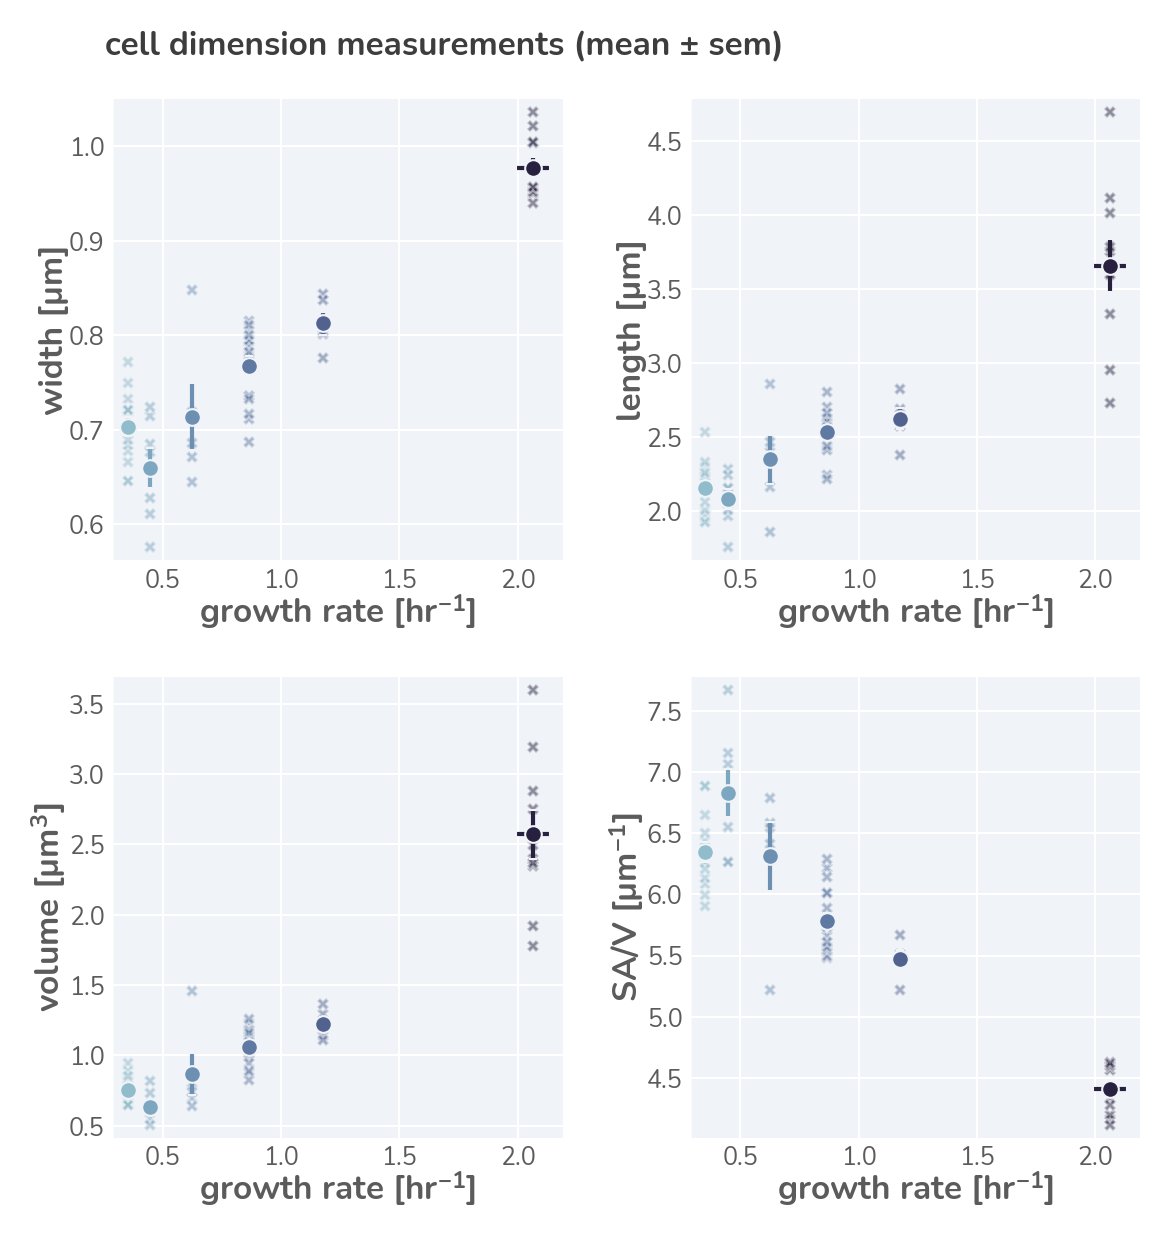

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(4, 4))
for a in ax.ravel():
    a.set_xlabel('growth rate [hr$^{-1}$]')
ax[0,0].set_ylabel('width [µm]')
ax[0,1].set_ylabel('length [µm]')
ax[1,0].set_ylabel('volume [µm$^{3}$]')
ax[1,1].set_ylabel('SA/V [µm$^{-1}$]')
for g, d in wt_sizes.groupby(['carbon_source']):

    _gr = growth_rates_agg[(growth_rates_agg['carbon_source']==g) & 
                           (growth_rates_agg['strain']=='WT')]
    surf = size.analytical.surface_area(d['length'].values.astype(float), d['width_median'].values.astype(float))
    if len(_gr) == 0:
        continue
    __gr = np.ones(len(d)) * _gr['mean'].values[0]
    ax[0,0].plot(__gr, d['width_median'].values.astype(float), 'X', color=carb_colors[g], alpha=0.5, ms=3)
    ax[0,0].errorbar(_gr['mean'].values[0], d['width_median'].values.astype(float).mean(), 
                      d['width_median'].values.astype(float).std() / np.sqrt(len(d)-1), _gr['sem'], marker='o', 
                      color=carb_colors[g], linewidth=1, ms=4)
    ax[0,1].plot(__gr, d['length'].values.astype(float), 'X', color=carb_colors[g], alpha=0.5, ms=3)
    ax[0,1].errorbar(_gr['mean'].values[0], d['length'].values.astype(float).mean(), 
                      d['length'].values.astype(float).std() / np.sqrt(len(d)-1), _gr['sem'], marker='o', 
                      color=carb_colors[g], linewidth=1, ms=4)

    ax[1,0].plot(__gr, d['volume'].values.astype(float), 'X', color=carb_colors[g], alpha=0.5, ms=3)
    ax[1,0].errorbar(_gr['mean'].values[0], d['volume'].values.astype(float).mean(), 
                      d['volume'].values.astype(float).std() / np.sqrt(len(d) - 1), _gr['sem'], marker='o', 
                      color=carb_colors[g], linewidth=1, ms=4)
    SAV = surf / d['volume'].values.astype(float)
    ax[1,1].plot(__gr, SAV, 'X', color=carb_colors[g], alpha=0.5, ms=3)
    ax[1,1].errorbar(_gr['mean'].values[0], np.mean(SAV), 
                      np.std(SAV) / np.sqrt(len(d)-1), _gr['sem'], marker='o', 
                      color=carb_colors[g], linewidth=1, ms=4)

fig.text(0.1, 1, 'cell dimension measurements (mean ± sem)', fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig('./cell_dimension_growth_rate.pdf', bbox_inches='tight')

/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1094: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1095: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1174: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1175: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


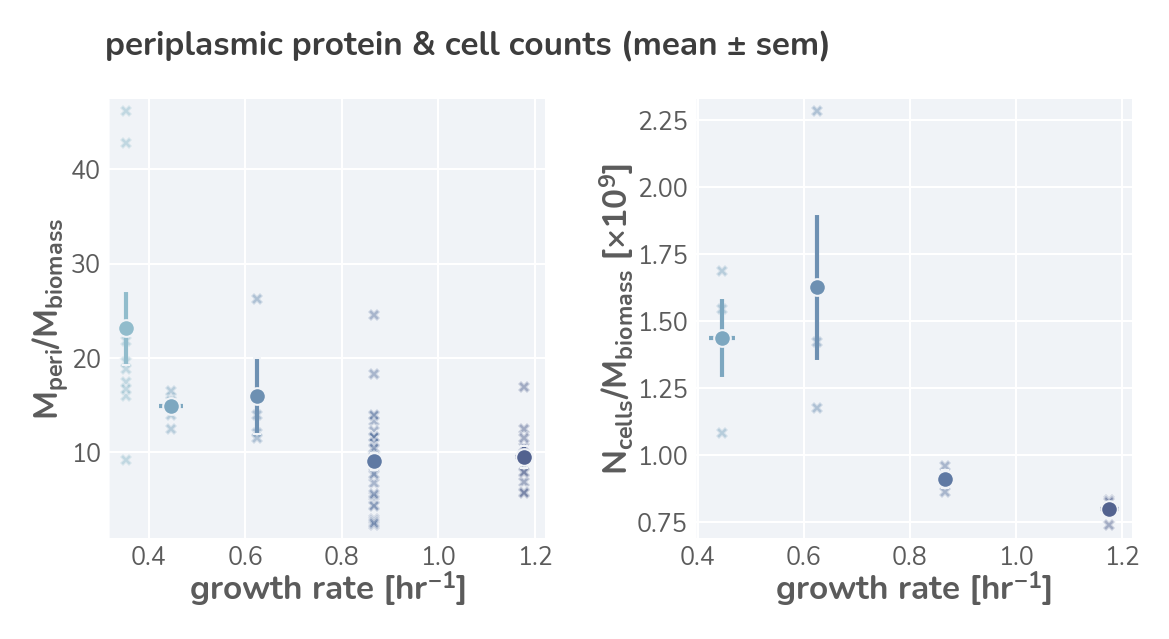

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
for a in ax:
    a.set_xlabel('growth rate [hr$^{-1}$]')
ax[0].set_ylabel('$M_{peri} / M_{biomass}$')
ax[1].set_ylabel(r'$N_{cells} / M_{biomass}$ [$\times$10$^9$]')
plt.tight_layout()

for g, d in growth_rates_agg.groupby(['carbon_source', 'strain']):
    if (g[1] != 'WT') & (g[1] != 'wildtype'):
        continue
    g = g[0]
    prot_agg = protein_agg[(protein_agg['carbon_source']==g) &
                       (protein_agg['strain']=='wildtype')]
    if len(prot_agg) == 0:
        continue
    prot = protein[(protein['carbon_source']==g) &
                       (protein['strain']=='wildtype')]
    prot_gr = np.ones(len(prot)) * d['mean'].values[0]
    ax[0].plot(prot_gr, prot['prot_ug_per_biomass'], 'X', color=carb_colors[g], alpha=0.5, ms=3)
    ax[0].errorbar(d['mean'].values[0], prot['prot_ug_per_biomass'].mean(), prot['prot_ug_per_biomass'].std() / np.sqrt(len(prot) - 1), d['sem'].values[0], marker='o', lw=1, ms=4,
                    color=carb_colors[g])


    counts = cell_counts_agg[(cell_counts_agg['carbon_source']==g) & 
                             (cell_counts_agg['strain']=='wildtype')]
    ax[1].plot(np.ones(len(counts)) * d['mean'].values[0], counts['cells_per_biomass'] / 1E9, 'X', color=carb_colors[g], alpha=0.5, ms=3)
    ax[1].errorbar(d['mean'].values[0], np.mean(counts['cells_per_biomass'] / 1E9), 
                np.std(counts['cells_per_biomass'] / 1E9) / np.sqrt(len(counts)), 
                d['sem'].values[0], marker='o', ms=4, lw=1, color=carb_colors[g])
fig.text(0.1, 1, 'periplasmic protein & cell counts (mean ± sem)', fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig('./peri_prot_counts.pdf', bbox_inches='tight')


## Protein concentration and scaling



/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1094: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1095: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1174: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1175: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/var/folders/sl/nj0m09b974n43bbv418vtmkr0000gp/T/ipykernel_49261/159283676.py:13: RuntimeWarning: invalid value encountered in double_scalars
  SAV_sem = np.std(SAV) / np.sqrt(len(SAV) - 1)


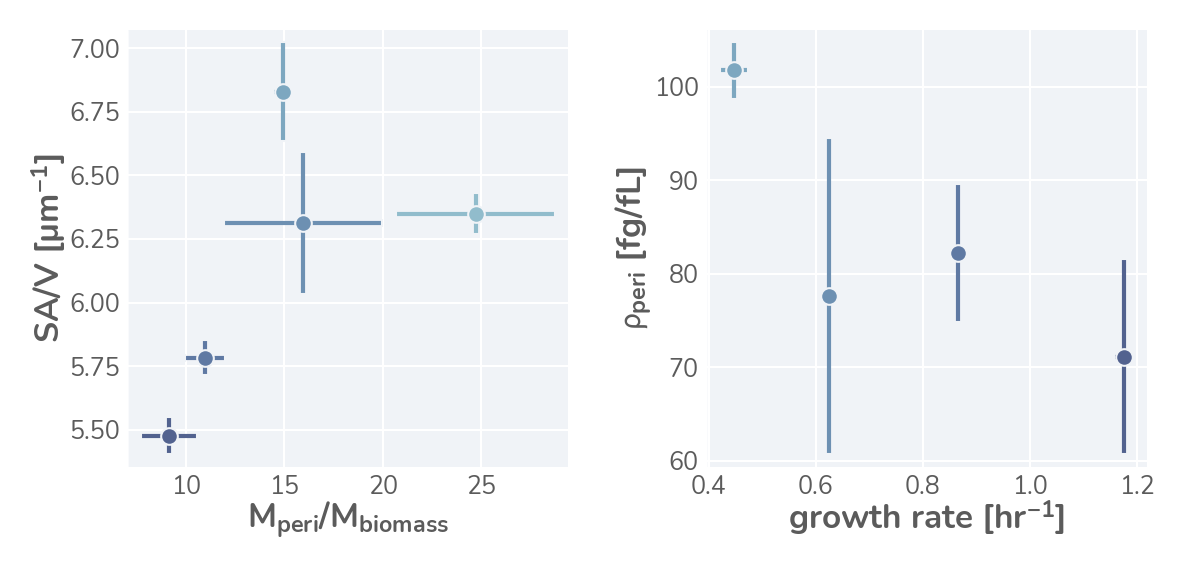

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

ax[0].set_ylabel('SA/V [µm$^{-1}$]')
ax[0].set_xlabel('$M_{peri}/M_{biomass}$')
ax[1].set_ylabel(r'$\rho_{peri}$ [fg/fL]')
ax[1].set_xlabel('growth rate [hr$^{-1}$]')

for g, d in wt_sizes.groupby('carbon_source'):
    SA = size.analytical.surface_area(d['width_median'].values.astype(float),
                                            d['length'].values.astype(float)) 
    SAV = SA / d['volume'].values.astype(float)
    SAV_mean = np.mean(SAV)
    SAV_sem = np.std(SAV) / np.sqrt(len(SAV) - 1)
    
    _prot = protein[(protein['carbon_source']==g) & 
                    (protein['strain']=='wildtype') & 
                    (protein['inducer_conc_ng_ml']==0)]
    if len(_prot) == 0:
        continue
    _prot_mean = _prot['prot_ug_per_biomass'].mean()
    _prot_sem = _prot['prot_ug_per_biomass'].std() / np.sqrt(len(_prot) -1)

    ax[0].errorbar(_prot_mean, SAV_mean, SAV_sem, _prot_sem, lw=1, marker='o', ms=4, 
                    color=carb_colors[g])
    _counts = cell_counts_agg[(cell_counts_agg['carbon_source']==g) & 
                              (cell_counts_agg['strain']=='wildtype')]
    _gr = growth_rates_agg[(growth_rates_agg['carbon_source']==g) & 
                            (growth_rates_agg['strain'].isin(['WT', 'wildtype']))]
    rho_mean = _prot_mean * 1E9 / (d['periplasm_volume'].values.astype(float).mean() * _counts['cells_per_biomass'].mean())
    rho_sem = np.std(_prot['prot_ug_per_biomass'] * 1E9 / (d['periplasm_volume'].values.astype(float).mean() * _counts['cells_per_biomass'].mean())) / np.sqrt(len(_prot) -1)
    ax[1].errorbar(_gr['mean'], rho_mean, rho_sem, _gr['sem'], color=carb_colors[g], marker='o', ms=4, lw=1)
plt.tight_layout()
plt.savefig('SAV_mperi_periplasmic_density.pdf')

### Computing the periplasmic mass fraction

In [146]:
# Compute a fit of cell volume as a function of growth rate. 
gr_dict = {g: d['mean'].values[0].astype(float) for g, d in growth_rates_agg[growth_rates_agg['strain']=='WT'].groupby(['carbon_source'])}
gr = [gr_dict[g] for g in wt_sizes[wt_sizes['carbon_source']!='ezMOPS'].carbon_source]
_wt_sizes = wt_sizes[wt_sizes['carbon_source']!='ezMOPS']
_wt_sizes['gr'] = gr

ell_popt = scipy.stats.linregress(_wt_sizes['gr'], np.log(_wt_sizes['length'].astype(float)))
w_popt = scipy.stats.linregress(_wt_sizes['gr'], _wt_sizes['width_median'].astype(float))


gr_range = np.linspace(0.2, 2.2, 200)
ell_fit = np.exp(ell_popt[0] * gr_range + ell_popt[1])
w_fit = w_popt[0] * gr_range + w_popt[1]


/var/folders/sl/nj0m09b974n43bbv418vtmkr0000gp/T/ipykernel_49261/2298524863.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _wt_sizes['gr'] = gr


In [177]:
mass_fracs = pd.read_csv('../../data/compiled_mass_fractions.csv')
peri_mass_fracs = mass_fracs[mass_fracs['periplasm']==True].groupby(['dataset_name', 'condition', 'growth_rate_hr'])['mass_frac'].sum().reset_index()

dry_frac = 0.3
prot_frac = 0.55
density = 1.1

# Compute the periplasmic protein density
peri_mass_fracs['width'] = w_popt[0] * peri_mass_fracs['growth_rate_hr'] + w_popt[1]
peri_mass_fracs['length'] = np.exp(ell_popt[0] * peri_mass_fracs['growth_rate_hr'] + ell_popt[1])
peri_mass_fracs['volume'] = size.analytical.volume(peri_mass_fracs['length'], peri_mass_fracs['width'])
peri_mass_fracs['peri_volume'] = size.analytical.surface_area(peri_mass_fracs['length'], peri_mass_fracs['width']) * 0.025
peri_mass_fracs['tot_protein'] = density * dry_frac * prot_frac * peri_mass_fracs['volume']
peri_mass_fracs['peri_protein'] = peri_mass_fracs['mass_frac'] * peri_mass_fracs['tot_protein']
peri_mass_fracs['rho_peri'] = (peri_mass_fracs['peri_protein']  * 1E3)/ peri_mass_fracs['peri_volume']


In [176]:
peri_mass_fracs

,dataset_name,condition,growth_rate_hr,mass_frac,width,length,volume,peri_volume,tot_protein,peri_protein,rho_peri
0,Caglar et al. 2017,gluconate_growth,0.663012,0.052317,0.733257,2.334616,0.882653,0.134450,0.160201,0.008381,0.062338
1,Caglar et al. 2017,glucose_time_course,0.774755,0.047316,0.752362,2.417190,0.963126,0.142833,0.174807,0.008271,0.057908
2,Li et al. 2014,MOPS complete,1.934364,0.019792,0.950621,3.467059,2.235841,0.258856,0.405805,0.008032,0.031027
3,Li et al. 2014,MOPS complete without methionine,1.569390,0.038918,0.888221,3.094975,1.734283,0.215908,0.314772,0.012250,0.056738
4,Li et al. 2014,MOPS minimal,0.738700,0.051521,0.746198,2.390232,0.936518,0.140083,0.169978,0.008757,0.062516
...,...,...,...,...,...,...,...,...,...,...,...
66,Valgepea et al. 2013,glucose_minimal,0.110000,0.107139,0.638709,1.965665,0.561589,0.098606,0.101928,0.010921,0.110749
67,Valgepea et al. 2013,glucose_minimal,0.210000,0.093849,0.655806,2.027769,0.611109,0.104444,0.110916,0.010409,0.099665
68,Valgepea et al. 2013,glucose_minimal,0.310000,0.085496,0.672903,2.091835,0.664145,0.110553,0.120542,0.010306,0.093222
69,Valgepea et al. 2013,glucose_minimal,0.400000,0.076313,0.688290,2.151223,0.715055,0.116291,0.129783,0.009904,0.085166


6    3.391960e+05
7    4.639970e+08
8    6.814122e+08
Name: cells_per_biomass, dtype: float64
Series([], Name: cells_per_biomass, dtype: float64)
9     8.638889e+08
10    9.583837e+08
Name: cells_per_biomass, dtype: float64
11    7.387967e+08
12    8.319901e+08
13    8.239416e+08
Name: cells_per_biomass, dtype: float64
14    1.174853e+09
15    2.280644e+09
16    1.420960e+09
Name: cells_per_biomass, dtype: float64
17    1.081189e+09
18    1.544557e+09
19    1.687237e+09
Name: cells_per_biomass, dtype: float64


/var/folders/sl/nj0m09b974n43bbv418vtmkr0000gp/T/ipykernel_49261/3652296937.py:33: RuntimeWarning: Mean of empty slice.
  rho_peri = ug_peri.mean() * 1E9 / (env_vol.mean() * n_cells)
/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


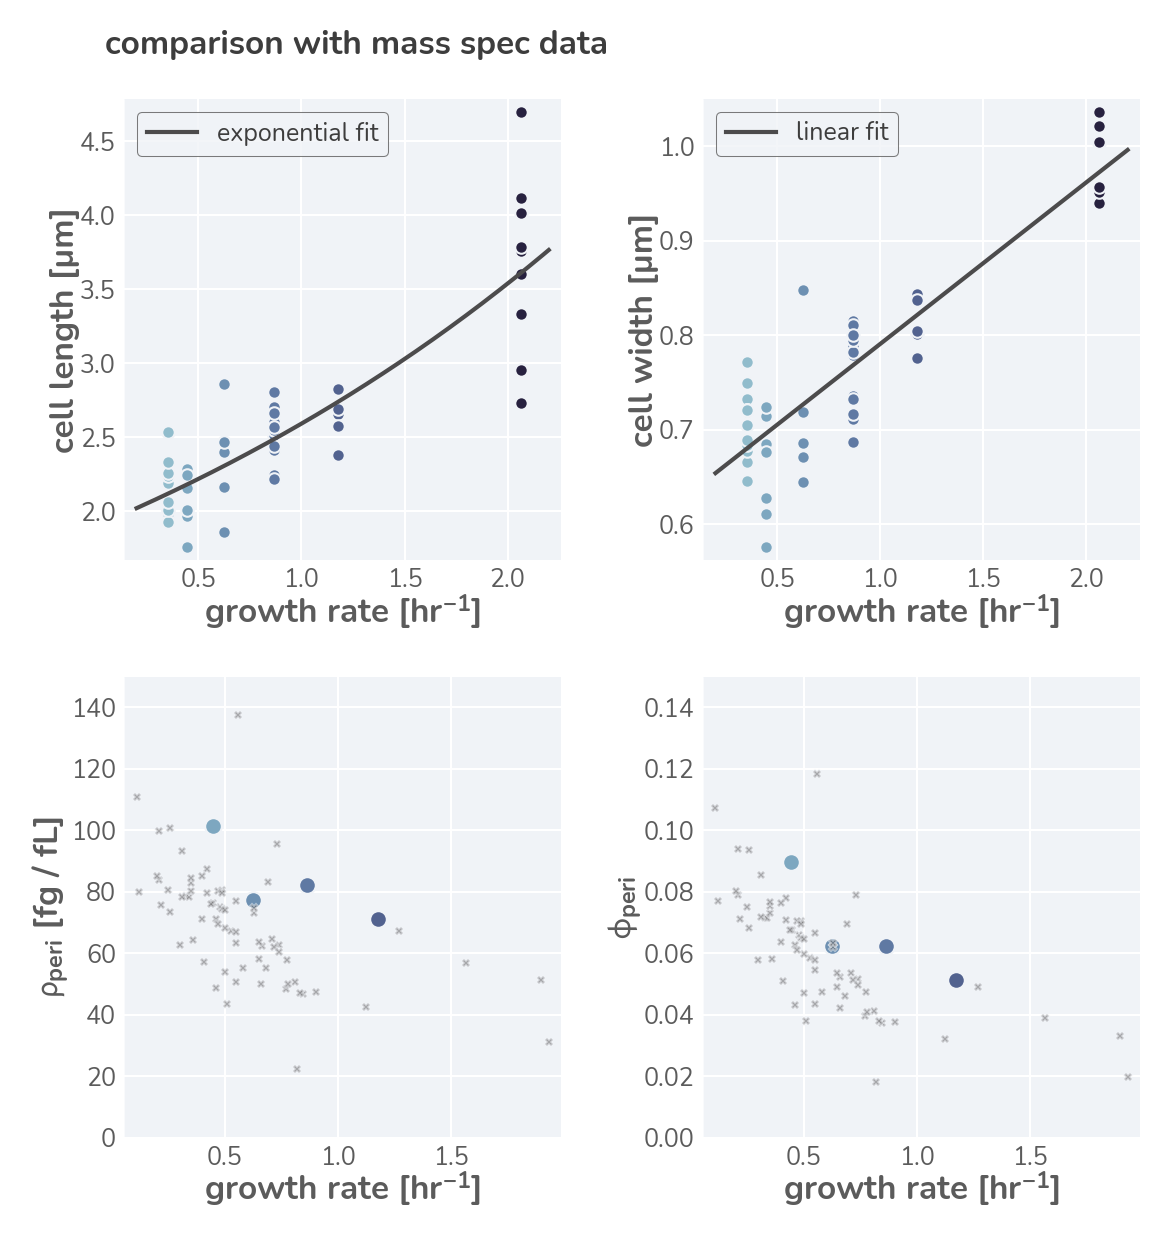

In [181]:
fig, ax = plt.subplots(2, 2, figsize=(4,4))
ax = ax.ravel()
for a in ax:
   a.set_xlabel('growth rate [hr$^{-1}$]')
ax[0].set_ylabel('cell length [µm]')
ax[1].set_ylabel('cell width [µm]')
ax[2].set_ylabel(r'$\rho_{peri}$ [fg / fL]')
ax[3].set_ylabel(r'$\phi_{peri}$')

for g, d in _wt_sizes.groupby(['carbon_source']):

   # Plot the size measuremenbts for the exponential fit
   ax[0].plot(d['gr'], d['length'].values.astype(float), 'o', ms=3, color=carb_colors[g], 
                label='__nolegend__')

   ax[1].plot(d['gr'], d['width_median'].values.astype(float), 'o', ms=3, color=carb_colors[g], 
                label='__nolegend__')

   # Compute the total cell protein density assuming 55% of dry mass is protein  
   dry_frac = 0.3
   prot_frac = 0.55
   density = 1.1E-6
   m_tot = density * dry_frac * prot_frac * d['volume'].values.astype(float).mean()
   n_cells = cell_counts_agg[(cell_counts_agg['carbon_source']==g) & (cell_counts_agg['strain']=='wildtype')]['cells_per_biomass']
   print(n_cells)
   if len(n_cells) == 0:
         continue
   n_cells = n_cells.mean()
   ug_prot = m_tot * n_cells
   env_vol = size.analytical.envelope_volume(d['length'].values.astype(float), d['width_median'].values.astype(float), 0.025)
   ug_peri = protein[(protein['carbon_source']==g) & (protein['strain']=='wildtype') & 
                     (protein['inducer_conc_ng_ml']==0)]['prot_ug_per_biomass'].values.astype(float)
   rho_peri = ug_peri.mean() * 1E9 / (env_vol.mean() * n_cells)
   if len(ug_peri) == 0:
      continue
   phi_peri = ug_peri.mean() / ug_prot
   ax[3].plot(d['gr'].mean(), phi_peri, 'o', ms=4, color=carb_colors[g])
   ax[2].plot(d['gr'].mean(), rho_peri, 'o', ms=4, color=carb_colors[g])

ax[0].plot(gr_range, ell_fit, lw=1, color=cor['primary_black'], label='exponential fit')
ax[1].plot(gr_range, w_fit, lw=1, color=cor['primary_black'], label='linear fit')

ax[2].plot(peri_mass_fracs['growth_rate_hr'], peri_mass_fracs['rho_peri'], 'X', ms=2, color=cor['primary_black'], alpha=0.5)
ax[3].plot(peri_mass_fracs['growth_rate_hr'], peri_mass_fracs['mass_frac'], 'X', ms=2, color=cor['primary_black'], alpha=0.5)

ax[2].set_ylim([0, 150])
ax[3].set_ylim([0, 0.15])
ax[0].legend(fontsize=6)
ax[1].legend(fontsize=6)
fig.text(0.1, 1, 'comparison with mass spec data', fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig('mass_spec_comparison.pdf')

In [171]:
mass_fracs

,gene_name,mass_frac,condition,strain,growth_rate_hr,dataset_name,go_terms,cog_class,cog_letter,periplasm
0,aas,0.000061,0.4% sodium acetate,NCM3722,0.50107,Mori et al. 2021,GO:0016874; GO:0016746; GO:0016740; GO:0016020...,metabolism,Q,False
1,accA,0.000429,0.4% sodium acetate,NCM3722,0.50107,Mori et al. 2021,GO:0016743; GO:0016740; GO:0042802; GO:0009317...,metabolism,I,False
2,accB,0.000578,0.4% sodium acetate,NCM3722,0.50107,Mori et al. 2021,GO:0009305; GO:0005829; GO:0005515; GO:0006631...,metabolism,H,False
3,accC,0.000782,0.4% sodium acetate,NCM3722,0.50107,Mori et al. 2021,GO:0005515; GO:0016874; GO:0006631; GO:0006629...,metabolism,I,False
4,accD,0.000496,0.4% sodium acetate,NCM3722,0.50107,Mori et al. 2021,GO:0016743; GO:0016740; GO:0009317; GO:0006631...,metabolism,I,False
...,...,...,...,...,...,...,...,...,...,...
146294,zapA,0.000061,glucose_minimal,MG1655,0.49000,Valgepea et al. 2013,GO:0090529; GO:0005886; GO:0005829; GO:0032153...,cellular processes and signaling,D,False
146295,zapB,0.000530,glucose_minimal,MG1655,0.49000,Valgepea et al. 2013,GO:0000917; GO:0032153; GO:0090529; GO:0036214...,cellular processes and signaling,D,False
146296,zipA,0.000211,glucose_minimal,MG1655,0.49000,Valgepea et al. 2013,GO:0043093; GO:0090529; GO:0032153; GO:0016021...,cellular processes and signaling,D,False
146297,zur,0.000022,glucose_minimal,MG1655,0.49000,Valgepea et al. 2013,GO:1900376; GO:0045892; GO:0044212; GO:0008270...,metabolism,P,False


In [145]:
mass_fracs

,dataset_name,growth_rate_hr,length,width,cell_volume_fL,envelope_volume_fL,drymass_fg,total_protein_mass_fg,periplasmic_protein_mass_fg,periplasmic_protein_density_fg_fL
0,Li et al. 2014,0.738700,2.873024,0.764042,1.147217,0.145306,573.608746,401.526123,20.686980,142.368633
1,Li et al. 2014,1.569390,4.519985,0.935262,2.715485,0.290595,1357.742646,950.419853,36.988030,127.283566
2,Li et al. 2014,1.934364,5.873163,1.022154,3.965134,0.420909,1982.567178,1387.797024,27.466741,65.255721
3,Peebo et al. 2015,0.210000,2.384356,0.671778,0.662951,0.104685,331.475526,232.032868,18.343157,175.223212
4,Peebo et al. 2015,0.220000,2.391221,0.673416,0.669863,0.105257,334.931643,234.452150,16.679101,158.460022
5,Peebo et al. 2015,0.250000,2.412274,0.678351,0.691035,0.107012,345.517713,241.862399,18.123423,169.358195
6,Peebo et al. 2015,0.260000,2.419446,0.680004,0.698240,0.107610,349.120241,244.384169,16.670517,154.916600
7,Peebo et al. 2015,0.310000,2.456507,0.688331,0.735408,0.110692,367.704199,257.392939,18.491854,167.057385
8,Peebo et al. 2015,0.350000,2.487649,0.695066,0.766562,0.113277,383.281129,268.296791,20.191975,178.252677
9,Peebo et al. 2015,0.360000,2.495650,0.696760,0.774555,0.113941,387.277396,271.094177,15.783558,138.523852


In [121]:
phi_peri

109    0.040106
118    0.035873
120    0.032243
122    0.038584
124    0.040632
126    0.042648
131    0.037885
139    0.039699
Name: prot_ug_per_biomass, dtype: float64

In [116]:
protein_agg

,strain,carbon_source,overexpression,inducer,inducer_conc_ng_ml,mean,sem
0,d2,acetate,none,none,0,14.246892,2.301870
1,d2,glucose,none,none,0,9.537385,NaN
2,d3,acetate,malE,ctc,10,10.270483,0.568653
3,d3,acetate,malE,ctc,30,11.185361,0.296289
4,d3,acetate,malE,ctc,50,14.404890,0.603106
5,d3,acetate,malE,ctc,100,14.634283,NaN
6,d3,acetate,none,none,0,10.711699,0.835824
7,d3,acetate,rbsB,ctc,10,20.209568,4.403142
8,d3,acetate,rbsB,ctc,30,32.081999,9.483082
9,d3,acetate,rbsB,ctc,50,24.198526,1.302334
